In [149]:
import numpy as np
import derpy
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Getting Started with Derpy

_written by Jaren N. Ashcraft_

In this tutorial we review the startup procedure for the Derp polarimeter using the `derpy` control software.

## Turn on the CRED2 Camera
- 1) plug the cable in to the big brick, Dexter's laboratory style
- 2) remove cover slip protecting the sensor

Next we initialize 

In [2]:
cam = derpy.CRED2(set_temperature=-40, fps=10, tint=10) # TODO: add units to docstring (also add docstring)

Updating...
Sensor Temperature: -40.02C
Motherboard Temperature: 37.5C
Frontend Temperature: 40.0C
Powerboard Temperature: 42.75C
Peltier Temperature: 14.09C
Heatsink Temperature: 36.2C
***********************
Sensor Temperature: -40.02C
Motherboard Temperature: 37.5C
Frontend Temperature: 40.0C
Powerboard Temperature: 42.75C
Peltier Temperature: 14.09C
Heatsink Temperature: 36.2C
***********************
Sensor Temperature: -40.02C
Motherboard Temperature: 37.5C
Frontend Temperature: 40.0C
Powerboard Temperature: 42.75C
Peltier Temperature: 14.09C
Heatsink Temperature: 36.2C
***********************
Sensor Temperature: -40.01C
Motherboard Temperature: 37.25C
Frontend Temperature: 40.0C
Powerboard Temperature: 43.0C
Peltier Temperature: 14.09C
Heatsink Temperature: 36.3C
***********************
Sensor Temperature: -40.03C
Motherboard Temperature: 37.25C
Frontend Temperature: 40.0C
Powerboard Temperature: 43.25C
Peltier Temperature: 14.08C
Heatsink Temperature: 36.4C
*********************

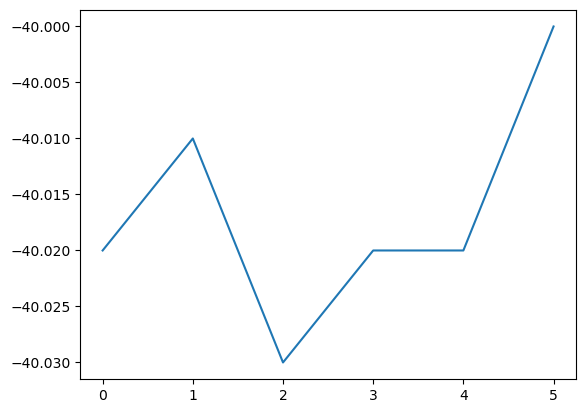

In [4]:
plt.plot(cam.temperature_change)

## Focus Stage
We begin with the linear translation stage that the CRED2 camera is mounted on. First, let's print what connected devices we have available.

In [2]:
derpy.print_connected_devices()

[('55346494', 'Kinesis K10CR1 Rotary Stage'), ('55344714', 'Kinesis K10CR1 Rotary Stage'), ('45452684', 'APT Stepper Motor Controller')]


That last element called `APT Stepper Motor Controller` is what we will be targeting. This ID is pre-loaded into `derpy.derpy_conf` so configure the Focus Stage.

In [3]:
derpy.FOCUS_STAGE_ID

45452684

We begin by establishing a connection to the Focus Stage, this is done by initializing the `FocusStage` class.

In [51]:
fstg = derpy.FocusStage()

c:\Users\EPL User\.conda\envs\pylablib_env\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model LTS150C; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


Pylablib throws some warnings because the stage is not natively supported, so we will need to perform a calibration of the focus stage eventually.

In [118]:
# 1e6 steps ~= 1mm
fstg.step(-1e6)

## Rotation Stages

Next we will show how to connect to the rotation stages on Derp. Similarlly to the Focus Stage, we will initialize the `RotationStage` class which automatically connects to the correct stage ID.

In [100]:
psg_stg = derpy.PSGRotationStage()
psa_stg = derpy.PSARotationStage()

In [102]:
psg_stg.step(-10)

## SuperK Laser
Yes it's actually called the SuperK laser. This is the final step in initializing Derp! 

TODO: Write setup procedure for SuperK

## Take a Test Image

In [283]:
dark = cam.take_many_images(10)

In [284]:
dark_med = np.median(dark, axis=0)

In [282]:
cam.tint = 0.05

In [300]:
cam.fps = 120

In [237]:
fstg.step(-1e6)

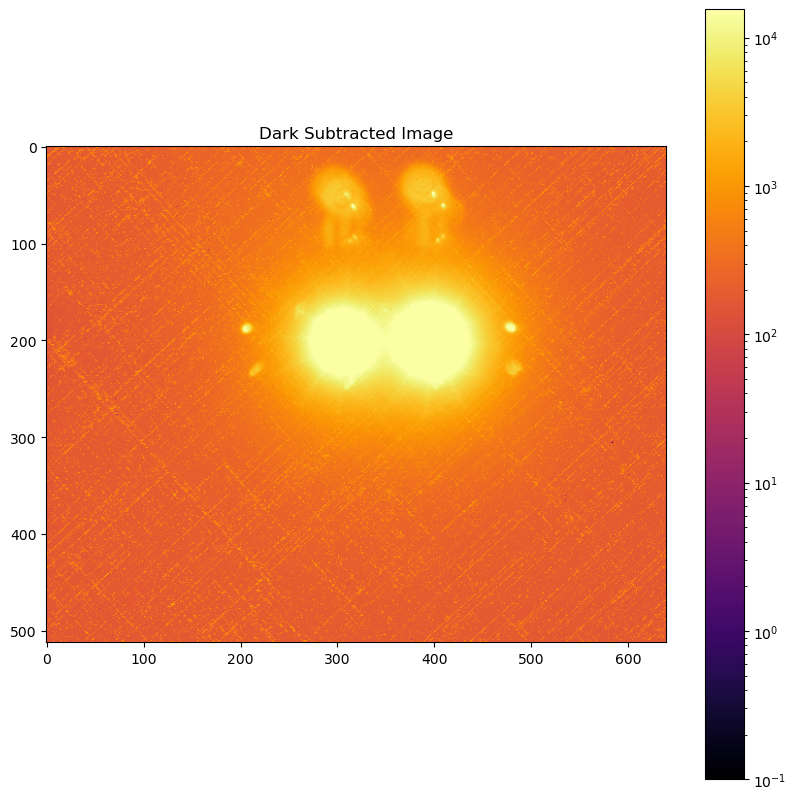

In [301]:
im = cam.take_many_images(10)
sleep(1)
im_med = np.median(im, axis=0)

vlim = None
cx, cy = 325, 200
cut = 200

processed = im_med.astype(np.float64) - dark_med.astype(np.float64)
processed[processed < 0] = 1e-10

plt.figure(figsize=[10, 10])
plt.title('Dark Subtracted Image')
plt.imshow(processed, cmap='inferno', norm=LogNorm(vmax=vlim, vmin=1e-1))
# plt.xlim(cx-cut, cx+cut)
# plt.ylim(cy-cut, cy+cut)
plt.colorbar()
plt.show()

# Testing Focus, Rotation Stages

In [2]:
derpy.print_connected_devices()

[('45452684', 'APT Stepper Motor Controller'), ('55344714', 'Kinesis K10CR1 Rotary Stage'), ('55346494', 'Kinesis K10CR1 Rotary Stage')]


In [3]:
fstg = derpy.FocusStage()

c:\Users\EPL User\.conda\envs\pylablib_env\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model LTS150C; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [4]:
psgstg = derpy.PSGRotationStage()
psastg = derpy.PSARotationStage()

In [5]:
psgstg.step(10)

In [6]:
psastg.step(10)

In [7]:
fstg.step(500000)

In [4]:
fstg.close()
psgstg.close()
psastg.close()

NameError: name 'psgstg' is not defined

# Testing CRED2 Camera

In [2]:
cam = derpy.CRED2(-39, fps=10, tint=1000)

Updating...
Sensor Temperature: -37.88C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 43.75C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.5C
***********************
Sensor Temperature: -37.88C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.48C
***********************
Sensor Temperature: -37.88C
Motherboard Temperature: 38.0C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 16.19C
Heatsink Temperature: 38.48C
***********************
Sensor Temperature: -35.59C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.0C
Peltier Temperature: 15.04C
Heatsink Temperature: 38.69C
***********************
Sensor Temperature: -37.82C
Motherboard Temperature: 38.25C
Frontend Temperature: 42.0C
Powerboard Temperature: 44.25C
Peltier Temperature: 13.76C
Heatsink Temperature: 39.24C
******************

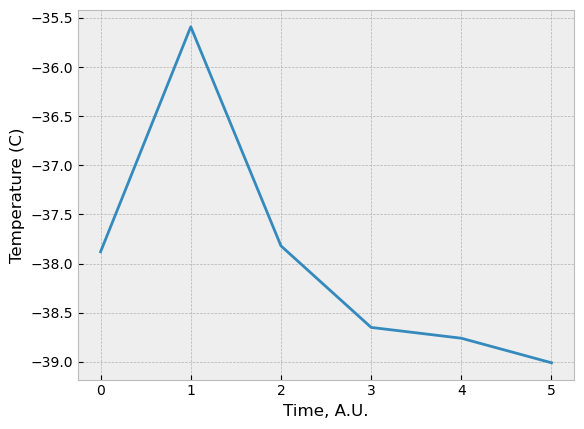

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

plt.figure()
plt.ylabel('Temperature (C)')
plt.xlabel('Time, A.U.')
plt.plot(cam.temperature_change, label='Temperature Change')
plt.show()

In [4]:
im = cam.take_image()

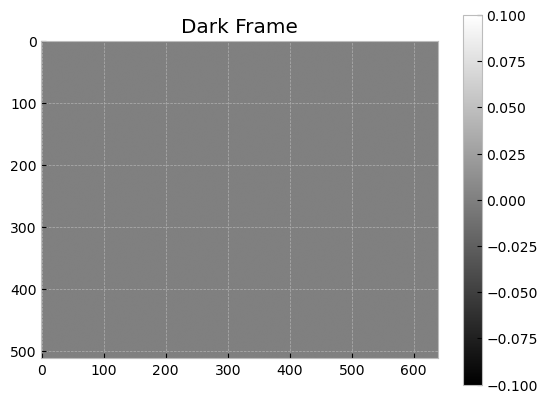

In [8]:
plt.figure()
plt.title('Dark Frame')
plt.imshow(im[0], cmap='gray')
plt.colorbar()
plt.show()

In [9]:
im[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
cam.close()

In [44]:
cam.tint = 50 # ms

In [56]:
im_light_50ms = cam.take_image()[0]
im_light_50ms.dtype

dtype('float64')

In [17]:
import FliSdk_V2 as sdk

im = sdk.GetRawImageAsNumpyArray(cam.context,0)

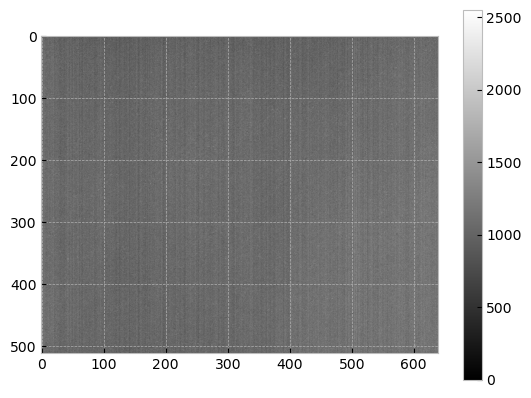

In [22]:
plt.imshow(im, cmap='gray', vmax=2550)
plt.colorbar()

In [32]:
im_light = sdk.GetRawImageAsNumpyArray(cam.context,0)

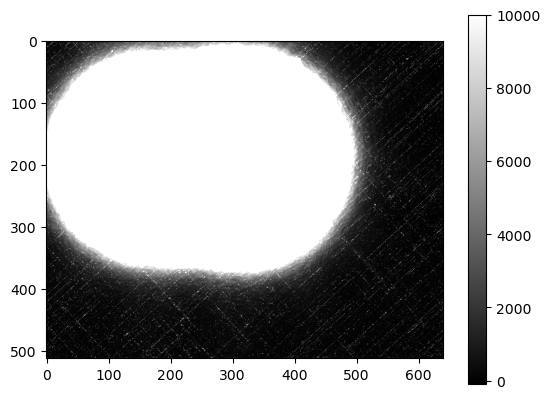

In [57]:
plt.style.use('default')
plt.imshow(im_light_50ms - im.astype(np.float64), cmap='gray',vmin=-100, vmax=10000)
plt.colorbar()